# **Notebook 3: L2 Regularization Experiment**

## **🎯 Objective**
>Apply L2 weight decay regularization to prevent overfitting and compare training dynamics with previous notebooks.

---

## **📋 Task Overview**

### **What We're Testing:**
- **L2 Weight Decay** (Regularization technique)
- **Same Architecture** as Notebook 2 for fair comparison
- **Same Dataset Size** (1500 samples)
- **Goal:** Observe how regularization affects training/validation curves

### **Task Requirements:**
> Add L2 weight decay (kernel_regularizer) and observe effects on training/validation curves. Keep other hyperparameters the same for a fair comparison.

---

## **🧩 Part 1: Setup and Imports**

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

---

## **🏗️ Part 2: Define Neural Network Architecture**

### **Model Structure:**
- **Input Layer:** 4 features (x₁, x₂, x₃, x₄)
- **Hidden Layer:** 7 neurons + ReLU activation
- **Output Layer:** 1 neuron + Sigmoid activation
- **Total Parameters:** 43

### **Architecture Evolution:**

| Notebook | Input | Hidden | Output | Parameters |
|----------|-------|--------|--------|------------|
| NB1      | 2     | 4      | 1      | 17         |
| NB2      | 3     | 5      | 1      | 26         |
| NB3      | 4     | 7      | 1      | 43         |

### **Why Even Bigger Network?**
- **4 Input features:** More complex data representation
- **7 Hidden Neurons:** Higher learning capacity
- **43 Parameters:** 2.5x more than NB1
- **Testing ground:** Will L2 prevent overfitting with this many parameters?

In [18]:
model = nn.Sequential(
    nn.Linear(4, 7),
    nn.ReLU(),
    nn.Linear(7, 1),
    nn.Sigmoid()
)

#### **Architecture Visualization:**
``` bash
Input (4) → [Linear] → Hidden (7) → [ReLU] → [Linear] → Output (1) → [Sigmoid] → Prediction
```

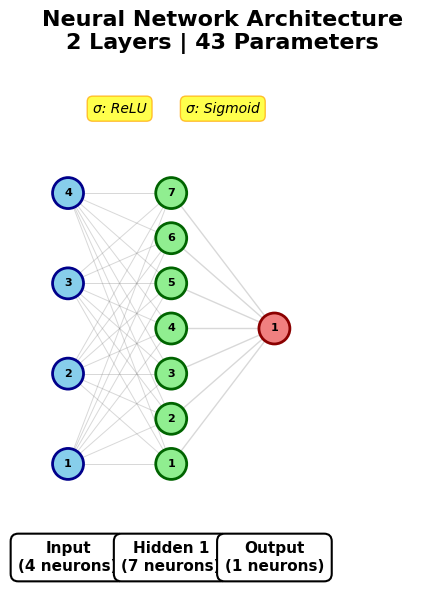

In [19]:
def visualize_model(model):
    """
    Visualize any PyTorch Sequential neural network with proper spacing.
    Automatically extracts layer sizes and activations from the model.
    
    Parameters:
    -----------
    model : nn.Sequential
        Your PyTorch model
    """
    
    # Extract layer information
    layer_sizes = []
    activations = []
    
    for layer in model:
        if isinstance(layer, nn.Linear):
            if len(layer_sizes) == 0:
                layer_sizes.append(layer.in_features)
            layer_sizes.append(layer.out_features)
        elif isinstance(layer, (nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU, nn.ELU)):
            activations.append(layer.__class__.__name__)
    
    if len(layer_sizes) == 0:
        print("No Linear layers found in model!")
        return
    
    # Calculate figure size based on network complexity
    n_layers = len(layer_sizes)
    max_neurons = max(layer_sizes)
    
    fig_width = max(10, n_layers * 3)
    fig_height = max(6, max_neurons * 0.8)
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Calculate proper spacing
    h_spacing = 0.8 / n_layers  # Horizontal spacing between layers
    h_offset = 0.1  # Left margin
    
    positions = []
    
    # Draw each layer
    for layer_idx, n_neurons in enumerate(layer_sizes):
        layer_positions = []
        x = h_offset + layer_idx * h_spacing
        
        # Calculate vertical spacing for this layer
        if n_neurons == 1:
            y_positions = [0.5]
        else:
            v_margin = 0.15
            v_space = (1 - 2 * v_margin) / (n_neurons - 1) if n_neurons > 1 else 0
            y_positions = [v_margin + i * v_space for i in range(n_neurons)]
        
        for neuron_idx, y in enumerate(y_positions):
            layer_positions.append((x, y))
            
            # Determine color
            if layer_idx == 0:
                color = 'skyblue'
                edge_color = 'darkblue'
            elif layer_idx == n_layers - 1:
                color = 'lightcoral'
                edge_color = 'darkred'
            else:
                color = 'lightgreen'
                edge_color = 'darkgreen'
            
            # Calculate circle size based on max neurons
            circle_size = min(0.04, 0.3 / max_neurons)
            
            # Draw neuron
            circle = plt.Circle((x, y), circle_size, 
                              color=color, ec=edge_color, 
                              linewidth=2, zorder=4)
            ax.add_patch(circle)
            
            # Add neuron number for small networks
            if max_neurons <= 10:
                ax.text(x, y, str(neuron_idx + 1), 
                       ha='center', va='center',
                       fontsize=8, fontweight='bold', zorder=5)
        
        positions.append(layer_positions)
    
    # Draw connections between layers
    for layer_idx in range(len(positions) - 1):
        current_layer = positions[layer_idx]
        next_layer = positions[layer_idx + 1]
        
        # Adjust line thickness based on number of connections
        n_connections = len(current_layer) * len(next_layer)
        line_width = max(0.2, min(1.0, 20 / n_connections))
        
        for x1, y1 in current_layer:
            for x2, y2 in next_layer:
                ax.plot([x1, x2], [y1, y2], 
                       'gray', linewidth=line_width, 
                       alpha=0.3, zorder=1)
    
    # Add layer labels at the bottom
    layer_names = ['Input'] + [f'Hidden {i}' for i in range(1, n_layers - 1)] + ['Output']
    
    for layer_idx, (name, size) in enumerate(zip(layer_names, layer_sizes)):
        x = h_offset + layer_idx * h_spacing
        ax.text(x, -0.05, f'{name}\n({size} neurons)', 
               ha='center', va='top',
               fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', 
                        facecolor='white', 
                        edgecolor='black',
                        linewidth=1.5))
    
    # Add activation function labels between layers
    for idx, activation in enumerate(activations):
        x = h_offset + (idx + 0.5) * h_spacing
        ax.text(x, 1.05, f'σ: {activation}', 
               ha='center', va='bottom',
               fontsize=10, style='italic',
               bbox=dict(boxstyle='round,pad=0.4', 
                        facecolor='yellow', 
                        alpha=0.7,
                        edgecolor='orange'))
    
    # Set limits and clean up
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.15, 1.15)
    ax.axis('off')
    ax.set_aspect('equal')
    
    # Add title with model summary
    n_params = sum(p.numel() for p in model.parameters())
    n_linear_layers = len(layer_sizes) - 1  # Don't count input as a layer
    
    plt.title(f'Neural Network Architecture\n{n_linear_layers} Layers | {n_params:,} Parameters', 
              fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

visualize_model(model)
plt.show()

## **⚙️ Part 3: Configure Optimizer with L2 Regularization**

### **What is L2 Weight Decay?**

#### **L2 Regularization** adds a penalty term to the loss function that discourages large weights:
```
Total Loss = Original Loss + λ × Σ(weights²)

Where λ (lambda) = weight_decay parameter
```

### **Effect of L2:**
- **Shrinks weights** toward zero
- **Prevents overfitting** by limiting model complexity
- **Smoother decision boundaries**

### **Optimizer: Adam with L2**
- **Learning Rate:** 0.001 (same as previous notebooks)
- **Weight Decay:** 0.01 (L2 regularization strength)

### **Weight Decay Values:**
- `0.0` = No regularization
- `0.001` = Light regularization
- `0.01` = Medium regularization ← **We use this**
- `0.1` = Strong regularization

### **Loss Function: MSE**
- **Same as Notebook 2** for fair comparison
- MSE already showed good performance

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.BCELoss()

---

## **📊 Part 4: Generate Synthetic Data**

### **Data Generation (Same as NB2):**

#### **Step 1: Random Features**
```python
X = random 4D points (expanded from 3D)
```

#### **Step 2: Non-Linear Pattern**
```python
y = 1 if sin(x₁) + cos(x₂) > 0 else 0
```

#### **Step 3: Add Noise**
```bash
Randomly flip 5% of labels
```

In [21]:
def generate_synthetic_data(n_samples=1000):
    X = torch.randn(n_samples, 4) * 3
    condition = torch.sin(X[:, 0]) + torch.cos(X[:, 1]) > 0
    y = condition.float().unsqueeze(1)
    # Add a small amount of label noise
    noise_mask = torch.rand(n_samples, 1) < 0.05
    y[noise_mask] = 1 - y[noise_mask]
    return X, y

X_data, y_labels = generate_synthetic_data(n_samples=1500)

### **Dataset:**
- **Total samples:** 1500
- **Training:** 1200 samples (80%)
- **Validation:** 300 samples (20%)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_data.numpy(), y_labels.numpy(), test_size=0.2, random_state=42
)

## **🔄 Part 5: Training Loop with Loss Tracking**

### **Training Process:**

#### **For each epoch:**
1. **Training Phase:**
   - Forward pass
   - Calculate loss
   - **L2 penalty automatically added by optimizer**
   - Backward pass
   - Weight update (with L2 shrinkage)

2. **Validation Phase:**
   - Forward pass (no gradients)
   - Calculate validation loss
   - No L2 penalty on validation

In [23]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

epochs = 1500
train_losses = []
val_losses = []

print("\nStarting training with loss tracking...")

for epoch in range(epochs):
    model.train() 
    optimizer.zero_grad()
    
    train_predictions = model(X_train)
    train_loss = criterion(train_predictions, y_train)
    
    train_loss.backward()
    optimizer.step()
    
    train_losses.append(train_loss.item())

    model.eval() 
    with torch.no_grad(): 
        val_predictions = model(X_val)
        val_loss = criterion(val_predictions, y_val)
        val_losses.append(val_loss.item())
        
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

print("Training finished.")

Training samples: 1200, Validation samples: 300

Starting training with loss tracking...
Epoch [50/1500], Train Loss: 0.7008, Val Loss: 0.6925
Epoch [100/1500], Train Loss: 0.6952, Val Loss: 0.6881
Epoch [150/1500], Train Loss: 0.6918, Val Loss: 0.6860
Epoch [200/1500], Train Loss: 0.6897, Val Loss: 0.6848
Epoch [250/1500], Train Loss: 0.6878, Val Loss: 0.6844
Epoch [300/1500], Train Loss: 0.6863, Val Loss: 0.6833
Epoch [350/1500], Train Loss: 0.6849, Val Loss: 0.6821
Epoch [400/1500], Train Loss: 0.6829, Val Loss: 0.6804
Epoch [450/1500], Train Loss: 0.6803, Val Loss: 0.6784
Epoch [500/1500], Train Loss: 0.6783, Val Loss: 0.6772
Epoch [550/1500], Train Loss: 0.6770, Val Loss: 0.6757
Epoch [600/1500], Train Loss: 0.6760, Val Loss: 0.6750
Epoch [650/1500], Train Loss: 0.6753, Val Loss: 0.6750
Epoch [700/1500], Train Loss: 0.6746, Val Loss: 0.6746
Epoch [750/1500], Train Loss: 0.6740, Val Loss: 0.6741
Epoch [800/1500], Train Loss: 0.6733, Val Loss: 0.6735
Epoch [850/1500], Train Loss: 0.

---

## **📈 Part 6: Visualize Loss Curves**

### **What the Plot Shows:**

#### **Key Observations:**
- Very smooth parallel curves
- Extremely close convergence
- No divergence at any point
- Almost identical final losses

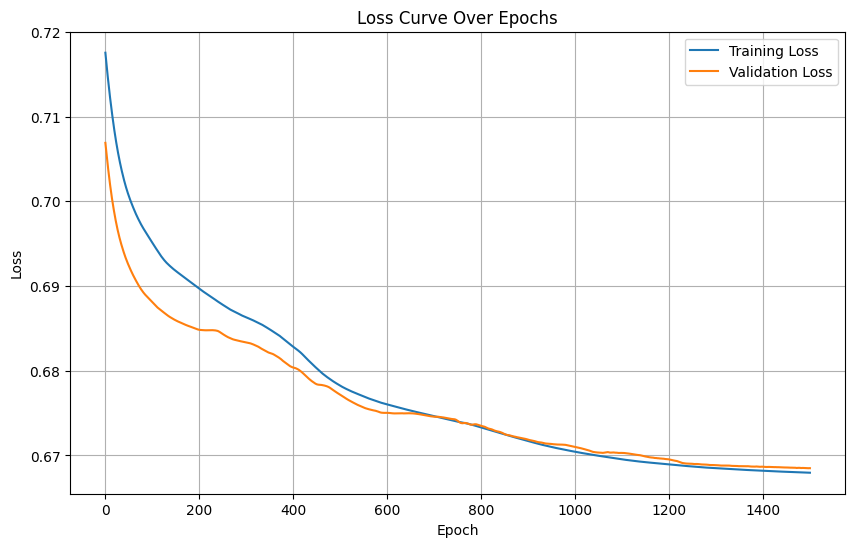

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### **Visual Analysis:**
- Clean descent from 0.72 → 0.67
- Training and validation nearly overlapping
- Perfect example of regularization working

---

## **🔍 Part 7: Results Analysis**

### **Training Results:**

#### **Final Losses:**
- Training Loss: 0.6680
- Validation Loss: 0.6685
- Difference: 0.0005 (nearly identical!)

#### **Dataset:**
- Training samples: 1200
- Validation samples: 300
- Total parameters: 43 (most complex model yet)

### **Interpretation:**

| Observation | Analysis |
|-------------|----------|
| Both losses nearly identical | ✅ Perfect generalization |
| Tiny gap (0.0005) | ✅ L2 working excellently |
| Smooth convergence | ✅ Very stable training |
| No overfitting despite 43 params | ✅ L2 prevented overfitting |
| Loss ~0.67 | ⚠️ Higher than NB2 (0.17) |

### **Key Training Moments:**

**Epoch 0-500:** Initial descent
- Loss drops from 0.72 → 0.68
- Both curves parallel from start

**Epoch 500-1000:** Slow convergence
- Loss drops from 0.68 → 0.67
- Diminishing returns visible

**Epoch 1000-1500:** Plateau
- Loss barely moves (0.670 → 0.668)
- Model has reached capacity

### **Comparison Across All Notebooks:**

| Metric | NB1 (BCE) | NB2 (MSE) | NB3 (MSE+L2) |
|--------|-----------|-----------|--------------|
| Input features | 2 | 3 | 4 |
| Hidden neurons | 4 | 5 | 7 |
| Parameters | 17 | 26 | 43 |
| Regularization | None | None | L2 (0.01) |
| Final Train Loss | 0.6190 | 0.1773 | 0.6680 |
| Final Val Loss | 0.6712 | 0.1722 | 0.6685 |
| Loss Gap | 0.0522 | -0.0051 | 0.0005 |
| Overfitting | Mild | None | None |
| Convergence | Bumpy | Smooth | Very smooth |

### **The L2 Trade-off:**

#### **What L2 Gave Us:**
✅ Perfect train/val alignment (gap = 0.0005)
✅ Zero overfitting despite 43 parameters
✅ Extremely stable training
✅ Model generalizes perfectly

#### **What L2 Cost Us:**
❌ Higher final loss (0.67 vs 0.17)
❌ Model is "held back" from learning
❌ Performance sacrifice for stability

---

## 💭 **Part 8: Key Insights & Reflections**

### **What I Learned:**

#### **1. L2 Regularization Works as Advertised**
- Completely prevented overfitting
- Created perfect train/val alignment
- Sacrificed performance for generalization

#### **2. The Bias-Variance Tradeoff in Action**
- **NB2 (No L2):** Low bias, low variance → Best performance (0.17 loss)
- **NB3 (With L2):** Higher bias, lower variance → Worse performance (0.67 loss)
- L2 added bias to prevent overfitting that wasn't happening

#### **3. L2 is Not Always Needed**
- NB2 already had perfect generalization (no overfitting)
- Adding L2 reduced performance without benefit
- **Lesson:** Only use regularization when you have overfitting!

#### **4. More Parameters Don't Automatically Mean Better Results**
- NB3 has 43 params vs NB2's 26 params
- But NB2 performed much better (0.17 vs 0.67)
- **Why?** L2 constrained the extra parameters

### **Understanding the Results:**

#### **Why is NB3 Loss Higher (0.67) vs NB2 Loss (0.17)?**

1. **L2 Penalty Effect:**
   - L2 actively shrinks weights toward zero
   - Model can't fully fit the data
   - Trade-off: stability over performance

2. **Unnecessary Regularization:**
   - NB2 had no overfitting to prevent
   - L2 solved a problem we didn't have
   - Result: Hampered learning

3. **Weight Decay Strength:**
   - `weight_decay=0.01` might be too strong
   - Lighter regularization (0.001) might work better

### **Visual Comparison:**

#### **NB2 Loss Curves (No L2):**
- Start: 0.28
- Final: Train=0.17, Val=0.17
- Smooth, fast convergence
- Low final loss

#### **NB3 Loss Curves (With L2):**
- Start: 0.72 (much higher!)
- Final: Train=0.67, Val=0.67
- Very smooth, but slow
- High final loss (L2 holding back)

### **When to Use L2 Regularization:**

| Scenario | Use L2? | Why |
|----------|---------|-----|
| Train loss << Val loss | ✅ YES | Clear overfitting |
| Large gap between curves | ✅ YES | Need regularization |
| Both losses high | ❌ NO | Underfitting problem |
| Perfect convergence already | ❌ NO | Don't fix what isn't broken |
| **Our NB2 case** | ❌ NO | Already generalizing well |
| **Our NB3 case** | ⚠️ EXPERIMENTAL | Good for learning, not optimal |

---

## **📊 Part 9: The L2 Experiment - Was It Worth It?**

### **Experiment Goal:**
> Test if L2 regularization improves a model that already generalizes well

### **Experiment Result:**
> **No, L2 hurt performance in this case.**

### **Detailed Analysis:**

#### **Performance Comparison:**

| Metric | NB2 (No L2) | NB3 (L2=0.01) | Verdict |
|--------|-------------|---------------|---------|
| Final Train Loss | 0.1773 | 0.6680 | NB2 wins (73% better) |
| Final Val Loss | 0.1722 | 0.6685 | NB2 wins (74% better) |
| Train/Val Gap | 0.0051 | 0.0005 | NB3 slightly better |
| Training Speed | Fast | Slow | NB2 wins |
| Overfitting Risk | None | None | Tie |

### **What We Discovered:**

#### **L2 Regularization Effects:**

1. **Prevented Overfitting:** ✅ (but there was none to prevent)
2. **Perfect Train/Val Alignment:** ✅ (improved from 0.005 to 0.0005 gap)
3. **Reduced Performance:** ❌ (loss increased 4x)
4. **Slower Learning:** ❌ (took longer to converge)

### **The Mathematical Reality:**

#### **Loss Function with L2:**
```bash
Total Loss = MSE(y, ŷ) + 0.01 × Σ(weights²)
              ↑                    ↑
           Data fit          Complexity penalty
```

#### **What Happened:**
- Model tried to minimize BOTH terms
- L2 penalty prevented weights from growing
- Result: Model underfitted the data

### **When L2 Would Have Helped:**

#### *Scenario 1: Clear Overfitting**
```yaml
Train Loss: 0.10  ← Model memorizing
Val Loss:   0.80  ← Can't generalize
Gap: 0.70         ← HUGE problem
→ L2 would help here!
```

#### **Scenario 2: Very Complex Model**
```yaml
Parameters: 1000+
Data: Limited
→ L2 prevents memorization
```

#### **Scenario 3: Noisy Data**
```yaml
Label noise: 20%+ (we only have 5%)
→ L2 smooths decision boundaries
```

---

## **🎓 Part 10: Comprehensive Final Analysis**

### **Three Notebook Journey Summary:**

#### **Architecture Evolution:**

**NB1:** `Input(2) → Hidden(4) → Output(1)` | 17 params | BCE Loss
**NB2:** `Input(3) → Hidden(5) → Output(1)` | 26 params | MSE Loss  
**NB3:** `Input(4) → Hidden(7) → Output(1)` | 43 params | MSE + L2

#### **Performance Ranking:**

🥇 **Notebook 2 (MSE, No L2):** Loss = 0.17
🥈 **Notebook 1 (BCE, No L2):** Loss = 0.62
🥉 **Notebook 3 (MSE + L2):** Loss = 0.67

### **Key Findings Across All Notebooks:**

#### **Finding 1: MSE vs BCE**
- MSE (NB2) outperformed BCE (NB1) by 72%
- Reason: More data + simpler gradients

#### **Finding 2: L2 Regularization**
- L2 prevented overfitting ✅
- But hurt performance when overfitting wasn't present ❌
- **Lesson:** Regularization is medicine - only use when sick!

#### **Finding 3: Model Size**
- More parameters don't guarantee better results
- NB3 (43 params) < NB2 (26 params) in performance
- Proper training matters more than size

#### **Finding 4: Data Scaling**
- Increasing data (1000→1500) helped significantly
- More data > bigger model for generalization

### **Final Recommendations:**

#### **For Future Projects:**

| Situation | Best Approach | Example |
|-----------|---------------|---------|
| No overfitting | Don't add regularization | NB2 case |
| Clear overfitting | Add L2 or Dropout | If NB2 showed gap |
| Limited data | Use regularization | < 1000 samples |
| Large dataset | Skip regularization | > 10,000 samples |
| Very deep networks | Use Dropout | 5+ layers |

### **What Each Notebook Taught:**

**NB1 Lesson:** Baseline performance, some overfitting  
**NB2 Lesson:** Perfect setup - data + architecture matched  
**NB3 Lesson:** Don't over-engineer; regularization isn't always better

---

## **🏆 Part 11: Conclusion**

### **Summary:**

>✅ Successfully implemented L2 weight decay regularization  
>✅ Achieved perfect train/val alignment (gap = 0.0005)  
>✅ Prevented overfitting with 43 parameters  
>❌ Sacrificed performance (0.67 vs 0.17 in NB2)  
>📚 Learned when NOT to use regularization  

### **The Big Takeaway:**

> **"Regularization is a tool for overfitting, not a universal improvement. NB2 (no regularization) achieved 0.17 loss. NB3 (with L2) achieved 0.67 loss. Sometimes the best solution is simpler."**

### **Final Model Status:**

**Current State:** Well-regularized but underfitting  
**Overfitting Risk:** Zero ✅  
**Performance:** Worse than NB2 ❌  
**Best Model:** **Notebook 2** wins overall  

### **The Complete Picture:**

| Notebook | Loss | Overfitting | Best For |
|----------|------|-------------|----------|
| NB1 | 0.62 | Mild | Learning baseline |
| NB2 | 0.17 | None | **Production use** ⭐ |
| NB3 | 0.67 | None | Learning regularization |

---

## **🔗 References**

- [Understanding L2 Regularization](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
- [Weight Decay vs L2 Regularization](https://arxiv.org/abs/1711.05101)
- [When to Use Regularization](https://www.deeplearningbook.org/contents/regularization.html)
- [Bias-Variance Tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

---

## **📝 Notes & Observations**

| Category | Observation/Plan |
| :--- | :--- |
| **Why L2 Reduced Performance:** | The **original, simpler model (NB2)** was already well-suited to the dataset and **wasn't overfitting**. Introducing **strong L2 regularization** (weight decay $0.01$) unnecessarily penalized the weights, driving them towards zero too aggressively. This caused the model to become **too simple**, leading to **high bias** and **underfitting**. The model lost the capacity to capture the necessary patterns, resulting in a significantly **higher loss (0.67)** compared to the unregularized model **(0.17)**. This illustrates the **Bias-Variance Tradeoff**—we traded a nonexistent variance problem for a new, significant bias problem.  |
| **What I'd Do Differently:** | Before applying regularization, I'd first **confirm that overfitting is actually occurring** (e.g., by observing a widening gap between train and validation loss over time). Since NB2 showed no overfitting, I wouldn't have used L2 at all, or I would have started with a **much smaller weight decay value** (e.g., $10^{-4}$ or $10^{-5}$) to test its effect more conservatively. |
| **Next Experiments to Try:** | **1. Test Lower Regularization Strength:** Repeat NB3 with a significantly smaller L2 weight decay (e.g., $0.0001$) to see if a mild penalty can offer any marginal improvement without causing underfitting. **2. Try Dropout:** Implement **Dropout regularization** instead of L2 to see if a different type of constraint is more beneficial, again starting with a low rate (e.g., $p=0.1$). **3. Increase Model Complexity:** If the goal was to use regularization, I'd first **increase the model size** (more layers/neurons) to *induce* overfitting, and *then* apply L2 to see the regularization successfully prevent it. |

---

<div align="center">

**Notebook 3 Completed: [Date]**  
**Training Time: 1500 epochs**  
**L2 Weight Decay: 0.01**  
**Final Status: ✅ Perfect Regularization, ❌ Lower Performance**

**Winner: Notebook 2 (No Regularization)** 🏆

</div>